# EECS 4404 Group Project
## Author: Oyinkansola Ajibola, Jianhui Qi, Muhammad Fahad Sohail, Kwonmin Bok

**Original Dataset Source: Shanks0465. (2019). <i>Braille Character Dataset</i> [Data set]. Kaggle. https://www.kaggle.com/datasets/shanks0465/braille-character-dataset**

# Braille Character Dataset Description  
This dataset was created for the purpose of training a CNN for Braille Character Recognition.

**Image Description:**  
Each image is a 28x28 image in Black and White Scale.
Each image name consists of the character alphabet and the number of the image and the type of data augmentation it went through.
(i.e whs - width height shift, rot - Rotation, dim - brightness)

**Dataset composition:**  
26 characters * 3 Augmentations * 20 different images of different augmentation values
(i.e different shift,rotational and brightness values.)

# 1 - Look at the big picture and frame the problem.

## Frame the problem
1. Supervised learning
2. A multi-class classification task
3. Batch learning

## Look at the big picture
Predict the image and classify the braille character to english character.  
It will help individuals with visual impairments to read the braille without physical touching.

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
# from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [2]:
# Create 
image_dir = Path("./dataset")
dir_list = list(image_dir.glob("*.jpg"))

In [3]:
len(dir_list)

1560

In [4]:
# Create 2 arrays to store image inputs and labels
labels = []
images = []

# Read image file and store RGB values into the array
# Read the name of the image file and store its classifier
for file in dir_list:
    image = cv2.imread(str(file))
    images.append(image)

    # Extract a file name of the image and transform the class to numeric value
    # Each file name of the image starts with its class
    # e.g.,) 'a1.JPG0dim.jpg' indicates the class of the image is 'a' and its numeric class is 0.
    #        Numeric classes are a = 0, b = 1, ... , and z = 25
    label = ord(os.path.basename(file)[0]) - ord('a')
    labels.append(label)

# Change the array to numpy array and normarlize RGB value to between 0 and 1
images = np.array(images) / 255.0
labels = np.array(labels)

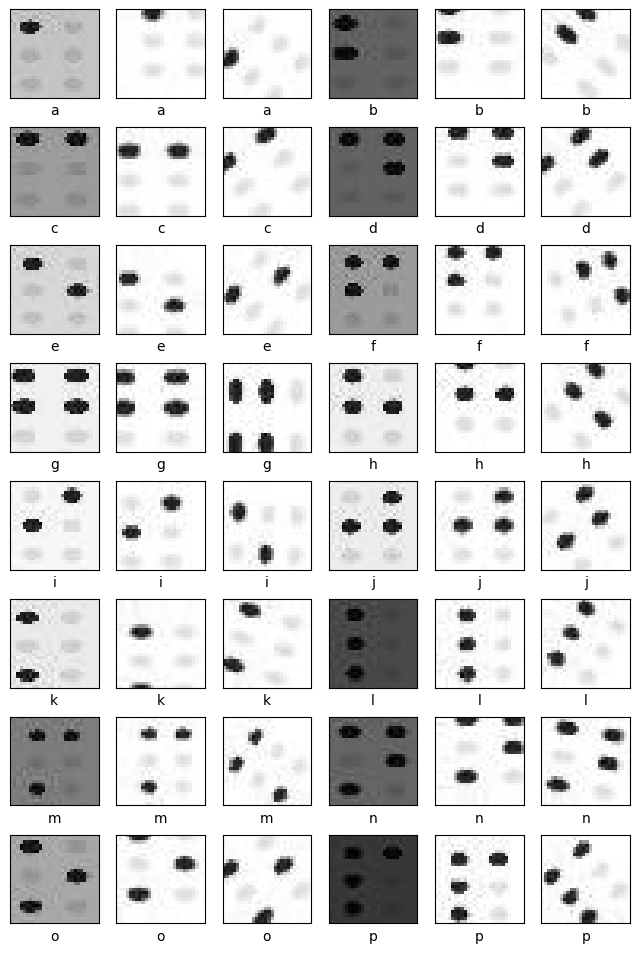

In [5]:
# To verify that the dataset is correctly transformed,
# plot 48 images from the image datasets with the class name below each image
plt.figure(figsize = (8, 12))
for i in range(48):
    plt.subplot(8, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i * 20])
    plt.xlabel(chr(labels[i * 20] + ord('a')))
plt.show()

In [6]:
# Split the dataset into 80% training set and 20% test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [7]:
# Create Convolutional Neural Network model
model = keras.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.25),   
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.25),   
    keras.layers.BatchNormalization(),

    # To complete the model, we need to dense to 26 layers(number of classes) to perform classification.
    # We need to flatten the layers first because the current output is a 3D tensor.
    # And then, densing the layers upto 26 layers.
    keras.layers.Flatten(),
    keras.layers.Dense(units=578, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=288, activation="relu"),
    keras.layers.Dense(units=26, activation="softmax") #output layer
])

In [8]:
model.compile(optimizer="Adam", loss="SparseCategoricalCrossentropy", metrics=["sparse_categorical_accuracy"])

In [9]:
from keras.callbacks import EarlyStopping

es1 = EarlyStopping(patience=20, monitor="val_sparse_categorical_accuracy", mode="auto")
es2 = EarlyStopping(patience=20, monitor="val_loss", mode="auto")

#The neural network will stop fitting if it gets 20 epochs without converge
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=100,
                    validation_split=0.3,
                    callbacks=[es1, es2])

Epoch 1/100


28/28 [==============================] - 2s 19ms/step - loss: 3.2623 - sparse_categorical_accuracy: 0.1134 - val_loss: 3.2718 - val_sparse_categorical_accuracy: 0.0427
Epoch 2/100
28/28 [==============================] - 0s 13ms/step - loss: 2.0192 - sparse_categorical_accuracy: 0.4044 - val_loss: 4.0422 - val_sparse_categorical_accuracy: 0.0427
Epoch 3/100
28/28 [==============================] - 0s 13ms/step - loss: 1.4148 - sparse_categorical_accuracy: 0.5865 - val_loss: 5.6461 - val_sparse_categorical_accuracy: 0.0427
Epoch 4/100
28/28 [==============================] - 0s 13ms/step - loss: 1.1149 - sparse_categorical_accuracy: 0.6770 - val_loss: 6.1478 - val_sparse_categorical_accuracy: 0.0427
Epoch 5/100
28/28 [==============================] - 0s 13ms/step - loss: 0.8802 - sparse_categorical_accuracy: 0.7365 - val_loss: 7.4691 - val_sparse_categorical_accuracy: 0.0427
Epoch 6/100
28/28 [==============================] - 0s 13ms/step - loss: 0.7030 - sparse_categori

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 14, 14, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                        

In [11]:
time = np.arange(1, len(history.history['loss'])+1)

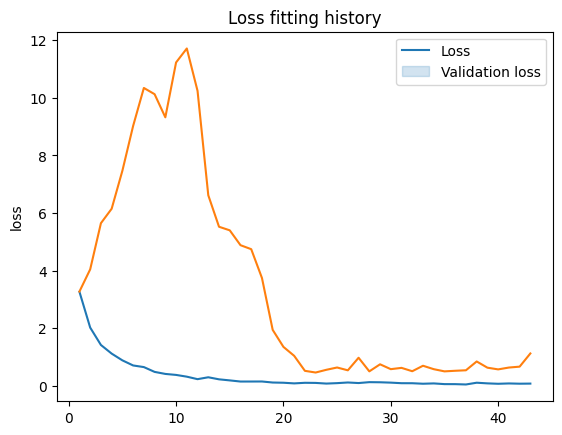

In [12]:
sns.lineplot(data=history.history, x=time, y='loss')
sns.lineplot(data=history.history, x=time, y='val_loss')
plt.title('Loss fitting history')
plt.legend(labels=['Loss', 'Validation loss'])
plt.show()

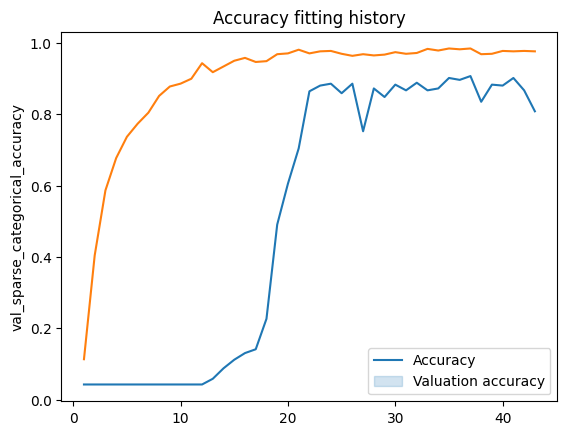

In [13]:
sns.lineplot(data=history.history, x=time, y='val_sparse_categorical_accuracy')
sns.lineplot(data=history.history, x=time, y='sparse_categorical_accuracy')
plt.title('Accuracy fitting history')
plt.legend(labels=['Accuracy', 'Valuation accuracy'])
plt.show()

In [14]:
print("Adam Optimizer")
model.evaluate(X_test, y_test)

Adam Optimizer
10/10 [==============================] - 0s 4ms/step - loss: 0.8943 - sparse_categorical_accuracy: 0.8141


[0.89434415102005, 0.8141025900840759]